In [84]:
!pip install kaggle matplotlib seaborn scikit-learn lightgbm

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# LightGBM
import lightgbm as lgb



You should consider upgrading via the 'C:\Users\murad\Desktop\anaKaggle\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [85]:
# Load the dataset
df = pd.read_csv('shades.csv')

# Inspect the data
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          625 non-null    object 
 1   brand_short    625 non-null    object 
 2   product        625 non-null    object 
 3   product_short  625 non-null    object 
 4   hex            625 non-null    object 
 5   H              613 non-null    float64
 6   S              613 non-null    float64
 7   V              613 non-null    float64
 8   L              625 non-null    int64  
 9   group          625 non-null    int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 49.0+ KB


,H,S,V,L,group
count,613.000000,613.000000,613.000000,625.000000,625.000000
mean,25.314845,0.459494,0.779543,65.920000,3.472000
std,5.327852,0.154089,0.173955,17.512267,1.976529
min,4.000000,0.100000,0.200000,11.000000,0.000000
25%,23.000000,0.350000,0.690000,55.000000,2.000000
50%,26.000000,0.440000,0.840000,71.000000,3.000000
75%,29.000000,0.560000,0.910000,79.000000,5.000000
max,45.000000,1.000000,1.000000,95.000000,7.000000


In [86]:
# Fill missing values for numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Fill missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

In [87]:
print("\nDataset Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          625 non-null    object 
 1   brand_short    625 non-null    object 
 2   product        625 non-null    object 
 3   product_short  625 non-null    object 
 4   hex            625 non-null    object 
 5   H              625 non-null    float64
 6   S              625 non-null    float64
 7   V              625 non-null    float64
 8   L              625 non-null    int64  
 9   group          625 non-null    int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 49.0+ KB

Missing Values:
brand            0
brand_short      0
product          0
product_short    0
hex              0
H                0
S                0
V                0
L                0
group            0
dtype: int64

Basic Statistics:
                H           S           V         

In [88]:
# Check for missing values
df.isnull().sum()

brand            0
brand_short      0
product          0
product_short    0
hex              0
H                0
S                0
V                0
L                0
group            0
dtype: int64

In [89]:
# Encode 'group' using LabelEncoder
le_group = LabelEncoder()
df['group_encoded'] = le_group.fit_transform(df['group'])

# Verify encoding
print(df[['group', 'group_encoded']].drop_duplicates())

df.head()


     group  group_encoded
0        2              2
167      0              0
207      3              3
292      4              4
404      1              1
444      5              5
494      6              6
568      7              7


,brand,brand_short,product,product_short,hex,H,S,V,L,group,group_encoded
0,Maybelline,mb,Fit Me,fmf,f3cfb3,26.0,0.26,0.95,86,2,2
1,Maybelline,mb,Fit Me,fmf,ffe3c2,32.0,0.24,1.00,92,2,2
2,Maybelline,mb,Fit Me,fmf,ffe0cd,23.0,0.20,1.00,91,2,2
3,Maybelline,mb,Fit Me,fmf,ffd3be,19.0,0.25,1.00,88,2,2
4,Maybelline,mb,Fit Me,fmf,bd9584,18.0,0.30,0.74,65,2,2


In [90]:
# Encode 'brand'
le_brand = LabelEncoder()
df['brand_encoded'] = le_brand.fit_transform(df['brand'])

# Verify encoding
df[['brand', 'brand_encoded']].drop_duplicates()


,brand,brand_encoded
0,Maybelline,26
40,bareMinerals,35
69,Estée Lauder,11
111,Revlon,31
133,L'Oréal,19
155,Covergirl + Olay,8
167,Fenty,12
207,Iman,16
215,Beauty Bakerie,1
245,Black Up,4


In [91]:
# Features: H, S, V, L, group_encoded
X = df[['H', 'S', 'V', 'L', 'group_encoded']]

# Target: brand_encoded
y = df['brand_encoded']


In [92]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [93]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [94]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Train HistGradientBoostingClassifier
hgb_model = HistGradientBoostingClassifier(random_state=42)
hgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_hgb = hgb_model.predict(X_test)
print("HistGradientBoosting Accuracy:", accuracy_score(y_test, y_pred_hgb))
print("Classification Report:\n", classification_report(y_test, y_pred_hgb))


HistGradientBoosting Accuracy: 0.544
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.57      0.67      0.62         6
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         3
           4       0.25      0.50      0.33         4
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         1
          10       0.50      0.50      0.50         2
          11       0.40      0.25      0.31         8
          12       1.00      1.00      1.00         8
          13       1.00      0.50      0.67         2
          14       1.00      1.00      1.00         2
          15       0.00      0.00      0.00         1
          16       1.00      0.50      0.67         2
          17       0

c:\Users\murad\Desktop\anaKaggle\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\murad\Desktop\anaKaggle\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\murad\Desktop\anaKaggle\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

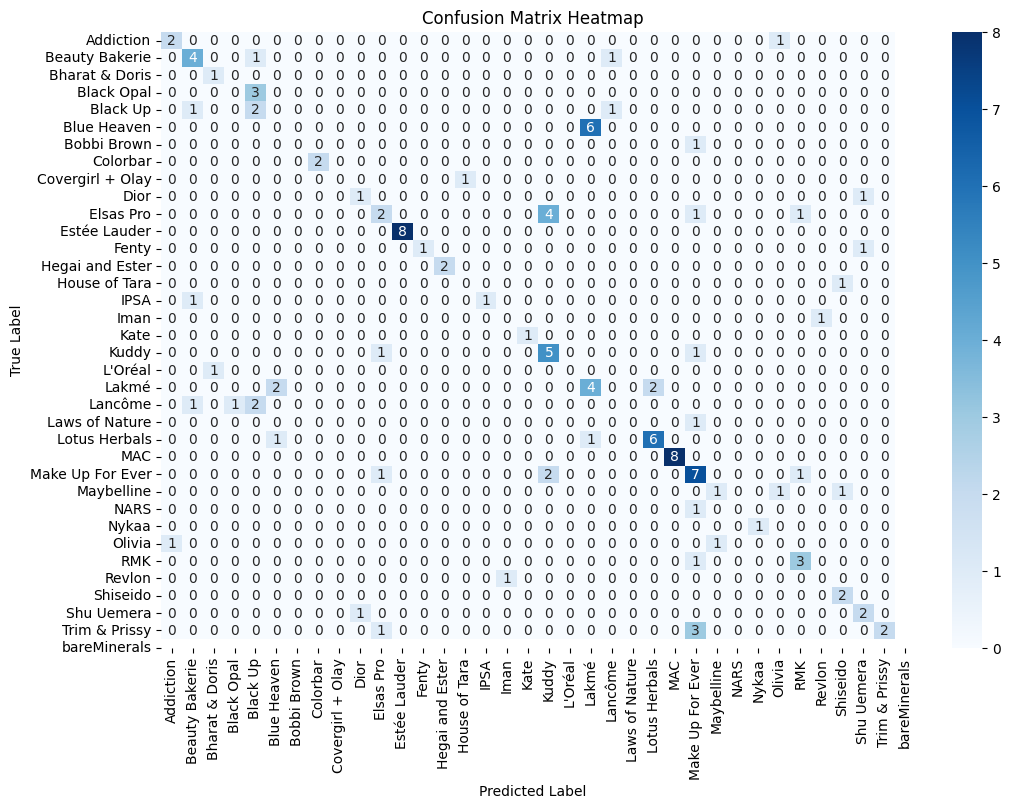

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_hgb)

# Plot as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le_brand.classes_, yticklabels=le_brand.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [96]:
# Compare predicted vs actual labels
comparison = pd.DataFrame({
    "True Label": le_brand.inverse_transform(y_test),
    "Predicted Label": le_brand.inverse_transform(y_pred_hgb)
})

# Display sample predictions
print(comparison.head(20))


          True Label   Predicted Label
0   Make Up For Ever  Make Up For Ever
1     Beauty Bakerie    Beauty Bakerie
2            Lancôme       Bobbi Brown
3   Make Up For Ever  Make Up For Ever
4   Make Up For Ever  Make Up For Ever
5            L'Oréal           L'Oréal
6         Maybelline        Maybelline
7            L'Oréal           L'Oréal
8         Maybelline        Maybelline
9       Estée Lauder            Revlon
10          Black Up    Beauty Bakerie
11        Maybelline        Maybelline
12     House of Tara     House of Tara
13         Addiction         Addiction
14       Bobbi Brown           Lancôme
15          Black Up          Black Up
16        Shu Uemera        Shu Uemera
17               RMK         Addiction
18             Fenty             Fenty
19        Maybelline      Estée Lauder


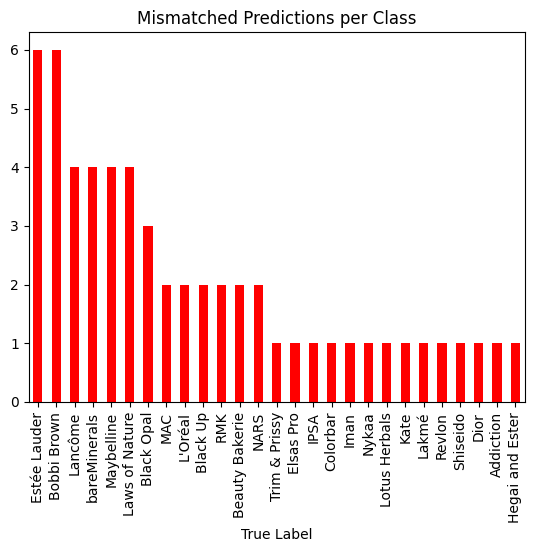

In [97]:
# Find mismatches
mismatches = comparison[comparison["True Label"] != comparison["Predicted Label"]]

# Count mismatches
mismatch_counts = mismatches["True Label"].value_counts()

# Plot mismatches
mismatch_counts.plot(kind="bar", color="red", title="Mismatched Predictions per Class")
plt.show()
